In [3]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
temp = torch.load("./data/cifar10_train.pt")
x, y = temp.data, temp.targets
print(x.shape)

(50000, 32, 32, 3)


In [19]:
train_ds = torch.load("./data/cifar10_train.pt")
train_dl = DataLoader(train_ds, batch_size=4, shuffle=False, num_workers=2)

test_ds = torch.load("./data/cifar10_test.pt")
test_dl = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=2)

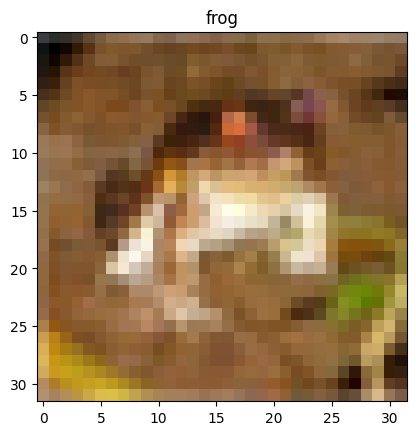

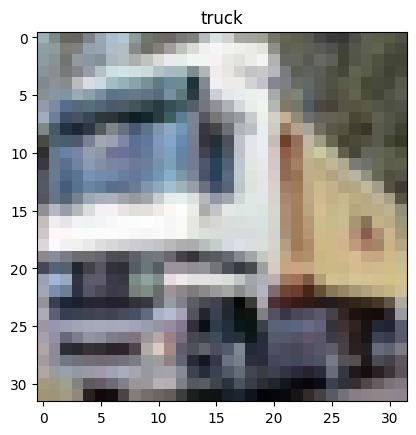

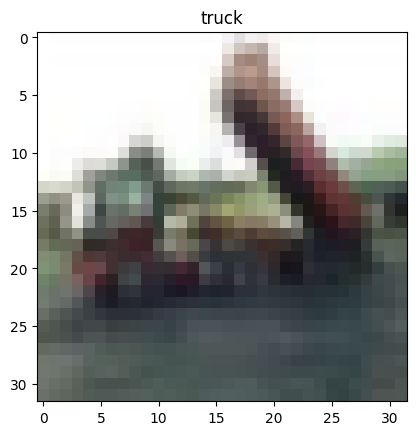

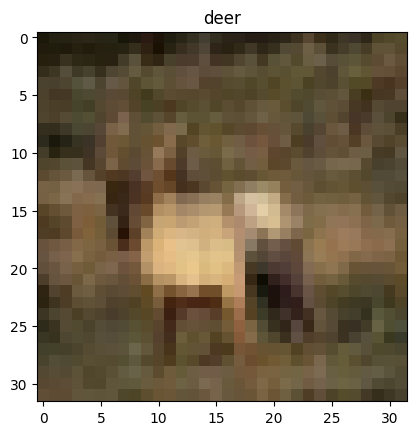

In [56]:
# get some random images from the dataloader
temp = iter(train_dl)
images, labels = next(temp)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def unormaize(image):
  img = image / 2 + 0.5
  return img.numpy()

for image, label in zip(images, labels):
  image = unormaize(image)
  plt.imshow(np.transpose(image, (1,2,0)))
  plt.title(classes[label])
  plt.show()

In [8]:
train_ds[0][0].shape[1]

32

# Network

In [9]:
class NuraleNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.cl1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.cl2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

    self.maxpool = nn.MaxPool2d(2,2)

    self.flatten = nn.Flatten()
    self.ln1 = nn.Linear(64*32, 1000) # 32 + 32 = 64
    self.ln2 = nn.Linear(1000, 500)
    self.ln3 = nn.Linear(500, 10)

    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.activation(self.cl1(x))
    x = self.maxpool(x)

    x = self.activation(self.cl2(x))
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.activation(self.ln1(x))
    x = self.activation(self.ln2(x))
    x = self.ln3(x)

    return x

# Training

In [10]:
model = NuraleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=0.001)

loss_data, epoch_data = [], []

for epoch in range(15):
  running_batch_loss = 0.0
  for i, (image, label) in enumerate(train_dl):
    image, label = image.to(device), label.to(device)
    optimizer.zero_grad()
    outputs = model(image)
    loss = criterion(outputs, label)
    loss.backward() # backward propergation
    optimizer.step()

    running_batch_loss += loss.item()
    epoch_data.append(epoch + i / len(train_dl))
    loss_data.append(loss.item())

    if i % 1500 == 1499:
      print("Epoche: {}, Loss: {}".format(epoch, running_batch_loss / 1500))
      running_batch_loss = 0.0

Epoche: 0, Loss: 1.8155765046676
Epoche: 0, Loss: 1.4941697147587936
Epoche: 0, Loss: 1.398123430987199
Epoche: 0, Loss: 1.2975124463538328
Epoche: 0, Loss: 1.224216619660457
Epoche: 0, Loss: 1.238932387592892
Epoche: 0, Loss: 1.1819541525145372
Epoche: 0, Loss: 1.1407005111277104
Epoche: 1, Loss: 1.082651619921128
Epoche: 1, Loss: 1.0382950690189998
Epoche: 1, Loss: 1.0233430837802588
Epoche: 1, Loss: 0.9855093312611183
Epoche: 1, Loss: 0.942763600817571
Epoche: 1, Loss: 0.9722324653229055
Epoche: 1, Loss: 0.9375988913259159
Epoche: 1, Loss: 0.8888148519104968
Epoche: 2, Loss: 0.8753207789547741
Epoche: 2, Loss: 0.8476427132509028
Epoche: 2, Loss: 0.8383006783751771
Epoche: 2, Loss: 0.8138158545397843
Epoche: 2, Loss: 0.7691021075978254
Epoche: 2, Loss: 0.7979299155479141
Epoche: 2, Loss: 0.7742478311308466
Epoche: 2, Loss: 0.7262612962754599
Epoche: 3, Loss: 0.7147949477987325
Epoche: 3, Loss: 0.7056666204488332
Epoche: 3, Loss: 0.694793096630024
Epoche: 3, Loss: 0.6777916699223449
E

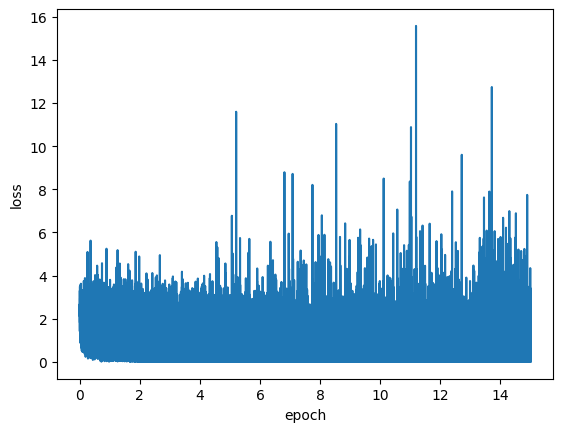

In [11]:
plt.plot(np.array(epoch_data), np.array(loss_data))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

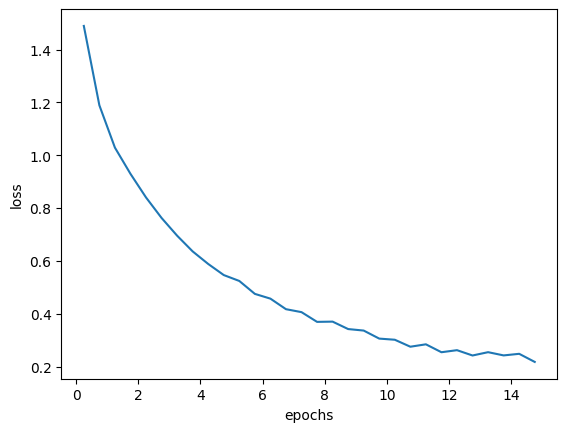

In [18]:
plt.plot(np.array(epoch_data).reshape(30, -1).mean(axis=1), np.array(loss_data).reshape(30, -1).mean(axis=1))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


# Precision
is calculated as the ratio between the number of Positive samples correctly classified to the total number of samples classified as Positive

# Recall
is calculated as the ratio between the number of Positive samples correctly classified as Positive to the total number of Positive samples

In [16]:
!pip install torchmetrics
from torchmetrics import Precision, Recall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 4.6 MB/s eta 0:00:00


In [25]:
precision = Precision(task="multiclass", num_classes=10, average="macro").to(device)
recall = Recall(task="multiclass", num_classes=10, average="macro").to(device)

model.eval()
with torch.no_grad():
  for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1) # Returns the maximum value of all elements in the input tensor, with a dim of 1
    precision(preds, labels)
    recall(preds, labels)

print("Precision: {} & Recall: {}".format(precision.compute(), recall.compute()))

Precision: 0.6530770659446716 & Recall: 0.645300030708313


In [26]:
precision = Precision(task="multiclass", num_classes=10, average="micro").to(device)
recall = Recall(task="multiclass", num_classes=10, average="micro").to(device)

model.eval()
with torch.no_grad():
  for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1) # Returns the maximum value of all elements in the input tensor, with a dim of 1
    precision(preds, labels)
    recall(preds, labels)

print("Precision: {} & Recall: {}".format(precision.compute(), recall.compute()))

Precision: 0.6452999711036682 & Recall: 0.6452999711036682


In [32]:
precision = Precision(task="multiclass", num_classes=10, average=None).to(device)
recall = Recall(task="multiclass", num_classes=10, average=None).to(device)

model.eval()
with torch.no_grad():
  for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1) # Returns the maximum value of all elements in the input tensor, with a dim of 1
    precision(preds, labels)
    recall(preds, labels)

precision_value = precision.compute()
recall_value=recall.compute()

precision_by_class = {
  k: precision_value[v].item()
  for k, v in test_ds.class_to_idx.items()
}


recall_by_class = {
  k: recall_value[v].item()
  for k, v in test_ds.class_to_idx.items()
}

print("Precision: {} \nRecall: {}".format(precision_by_class, recall_by_class))

Precision: {'airplane': 0.7962716221809387, 'automobile': 0.8225291967391968, 'bird': 0.5472312569618225, 'cat': 0.46395349502563477, 'deer': 0.5993449687957764, 'dog': 0.46863189339637756, 'frog': 0.7330595254898071, 'horse': 0.6078431606292725, 'ship': 0.7744510769844055, 'truck': 0.717454195022583} 
Recall: {'airplane': 0.5979999899864197, 'automobile': 0.7739999890327454, 'bird': 0.5040000081062317, 'cat': 0.39899998903274536, 'deer': 0.5490000247955322, 'dog': 0.6200000047683716, 'frog': 0.7139999866485596, 'horse': 0.7749999761581421, 'ship': 0.7760000228881836, 'truck': 0.7440000176429749}


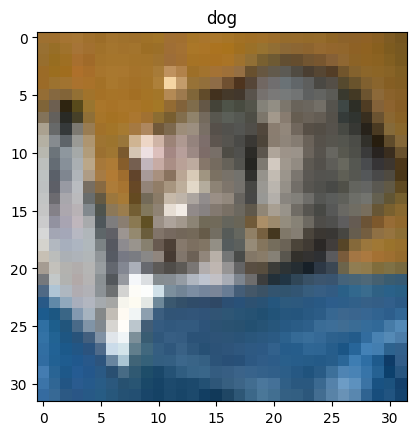

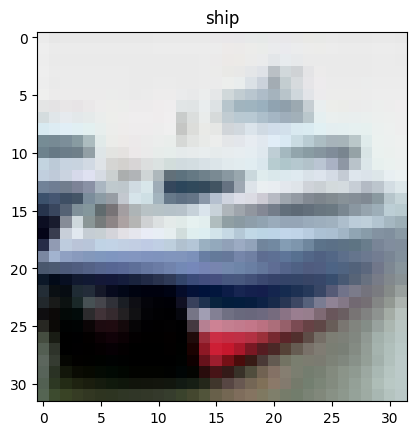

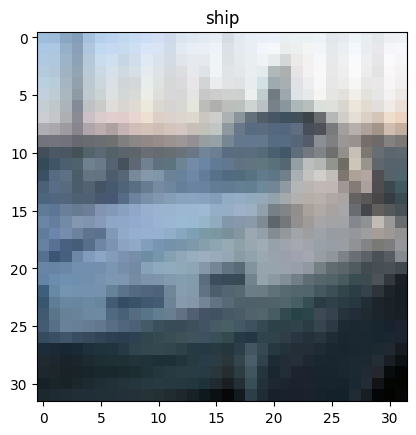

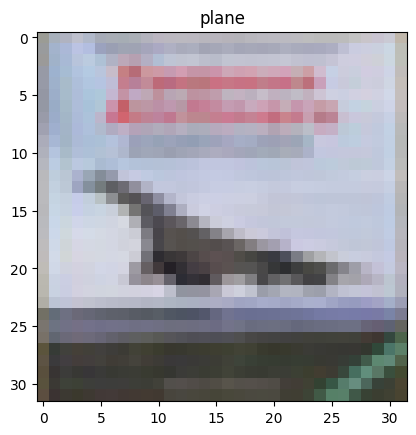

In [114]:
def unnormalize(image):
    img = image / 2 + 0.5
    return img

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

temp = iter(test_dl)


# Display 50 images
images, _ = next(temp)
images = images.to(device)
outputs = model(images)
_, labels = torch.max(outputs, 1)

for image, label in zip(images, labels):
  image = unormaize(image.cpu())
  plt.imshow(np.transpose(image, (1,2,0)))
  plt.title(classes[label])
  plt.show()
